In [1]:
%%capture
!pip install datasets pandas evaluate numpy
!pip install transformers[torch]

In [2]:
import pandas as pd
import json
import transformers
import datasets
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
)

from sklearn.model_selection import train_test_split
from datasets import Dataset
import numpy as np
import evaluate

import torch
import torch.nn as nn
from transformers import AutoModel, AutoModelForSequenceClassification
from transformers import AdamW

from sklearn.metrics import balanced_accuracy_score, f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import classification_report


In [3]:
import random


SEED = 45

# Устанавливаем сиды для основных библиотек
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

## **Загрузка размеченных данных и обучение трансформера**

In [4]:
# Загрузка данных
df = pd.read_csv('/content/data.tsv', sep='\t')
df.head()

,title,score,link,summary,published,tickers
0,Электромобильный стартап Arrival экс-главы Yot...,-0.583333,https://www.rbc.ru/technology_and_media/12/05/...,"Британский электромобильный стартап Arrival, к...","Thu, 12 May 2022 05:10:01 +0300",['ARVL']
1,Экс-глава НМТП рассказал о «напряженных отноше...,-0.314286,https://www.rbc.ru/society/16/11/2020/5fb2709d...,Экс-председатель совета директоров Новороссийс...,"Fri, 20 May 2022 19:13:18 +0300",['NMTP']
2,Шрёдер отклонил предложение войти в совет дире...,-0.333333,https://www.rbc.ru/business/20/05/2022/628772b...,Его кандидатуру выдвинули в начале февраля. Ка...,"Tue, 24 May 2022 22:12:05 +0300",['GAZP']
3,Шельф берут в разработку // Генподрядчиком «Га...,0.700000,https://www.kommersant.ru/doc/5482398,"Как стало известно “Ъ”, «Аврора» Андрея Патруш...","Fri, 29 Jul 2022 00:28:00 +0300",['GAZP']
4,"Чистый убыток ""Юнипро"" в 1 полугодии 2022 года...",-0.611111,https://www.finam.ru/analysis/newsitem/chistyi...,"Чистый убыток ""Юнипро"" в 1 полугодии 2022 года...","Thu, 28 Jul 2022 12:43:00 +0300",['UPRO']


In [5]:
# Найдем максимальную длину заголовка текста (необходимо для передачи параметра max_length в токенизаторе в дальнейшем)

max(df['title'].apply(lambda x: len(x)))

122

In [6]:
# Инициализация модели

model = AutoModelForSequenceClassification.from_pretrained(
    "DeepPavlov/rubert-base-cased-sentence", num_labels=1)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased-sentence and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
# Выбор токенизатора и создание функции для токенизации текста
tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased-sentence")
def token(text):
    return tokenizer(text['text'], padding=True, truncation=True, max_length=122)

In [8]:
# Разделение на обучающую и валидационную выборки
X_train, X_test, y_train, y_test = train_test_split(df['title'], df['score'], random_state=42,
                                                   shuffle=True, test_size=0.1)

In [9]:
df_train = pd.DataFrame(data={
    'text': X_train,
    'label': y_train
})
df_test = pd.DataFrame(data={
    'text': X_test,
    'label': y_test
})

In [10]:
# Преобразование обучающего и валидационного набора данных в формат, ожидаемый моделью и их токенизация
train = Dataset.from_pandas(df_train)
test = Dataset.from_pandas(df_test)
tokenized_train = train.map(token)
tokenized_test = test.map(token)

Map:   0%|          | 0/478 [00:00<?, ? examples/s]

Map:   0%|          | 0/54 [00:00<?, ? examples/s]

In [11]:
def compute_metrics(eval_pred):
    """
    Вычисляет метрики для оценки качества предсказаний модели.

    Параметры:
    ----------
    eval_pred : tuple
        Кортеж, содержащий два элемента:
        - logits (numpy.ndarray): Предсказанные значения (логиты) модели.
        - labels (numpy.ndarray): Истинные значения (метки).

    Возвращает:
    ----------
    dict
        Словарь с вычисленными метриками:
        - "mse" (float): Среднеквадратичная ошибка (Mean Squared Error).
        - "mae" (float): Средняя абсолютная ошибка (Mean Absolute Error).
        - "r2" (float): Коэффициент детерминации (R-squared).
        - "accuracy" (float): Доля предсказаний, которые находятся в пределах 0.5 от истинных значений.

    Примечания:
    ----------
    Точность (accuracy) рассчитывается как доля предсказанных значений,
    для которых квадрат разности между предсказанным и истинным значениями
    меньше 0.25.
    """

    logits, labels = eval_pred
    labels = labels.reshape(-1, 1)

    mse = mean_squared_error(labels, logits)
    mae = mean_absolute_error(labels, logits)
    r2 = r2_score(labels, logits)
    single_squared_errors = ((logits - labels).flatten()**2).tolist()

    # Рассчитаем точность(accuracy)
    # Исходим из того, что rounded score = true score только если |single_squared_errors| < 0.5
    accuracy = sum([1 for e in single_squared_errors if e < 0.25]) / len(single_squared_errors)


    return {"mse": mse, "mae": mae, "r2": r2, "accuracy": accuracy}

In [12]:
# Настройка конфигурации загрузчика данных и создание коллатора данных

from accelerate import Accelerator, DataLoaderConfiguration
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
accelerator = Accelerator(dataloader_config=dataloader_config)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [13]:
import wandb

wandb.init(mode='disabled')


In [14]:
# Устанавливаем гиперпараметры
training_args = TrainingArguments(
    output_dir="content/tuned_model",
    seed=SEED,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    warmup_steps=500,
    eval_strategy="epoch",
    save_strategy="epoch",
    remove_unused_columns=True,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    logging_steps=100,
)

# Инициализация тренера
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    processing_class=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)


In [15]:
# Запускаем обучение
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Epoch,Training Loss,Validation Loss,Mse,Mae,R2,Accuracy
1,No log,0.244085,0.244085,0.432214,0.072084,0.555556
2,No log,0.180366,0.180366,0.369639,0.314318,0.722222
3,No log,0.125699,0.125699,0.283300,0.522140,0.851852
4,0.220100,0.099051,0.099051,0.242054,0.623448,0.851852
5,0.220100,0.100964,0.100964,0.247519,0.616175,0.907407


TrainOutput(global_step=150, training_loss=0.1744036293029785, metrics={'train_runtime': 132.769, 'train_samples_per_second': 18.001, 'train_steps_per_second': 1.13, 'total_flos': 27230721956340.0, 'train_loss': 0.1744036293029785, 'epoch': 5.0})

Точность лучшей модели после настройки параметров составила ca. 91%. Сохраним ее  для дальнейшего использования при разметке новостных заголовков.

In [16]:
# Сохраняем лучшую модель в переменную
my_model = trainer.model

# Проверяем, что модель доступна
print(my_model)  # Ахитектура модели

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [17]:
my_model.save_pretrained("best_model_directory")
tokenizer.save_pretrained("best_model_directory")

('best_model_directory/tokenizer_config.json',
 'best_model_directory/special_tokens_map.json',
 'best_model_directory/vocab.txt',
 'best_model_directory/added_tokens.json',
 'best_model_directory/tokenizer.json')

## **Загрузка набора неразмеченных новостей c сайта finam.ru, разметка и дообучение модели.**

In [ ]:
# Загрузка данных
news = pd.read_csv('/content/finam_news.csv', sep=';')
news.head()

,Link,Date,Source,Title,Description
0,https://www.finam.ru/publications/item/rossiya...,2024-01-01,Finam.ru,Россия и Турция начнут обсуждение дорожной кар...,Турция рассчитывает завершить работы по создан...
1,https://www.finam.ru/publications/item/rossiya...,2024-01-01,Finam.ru,Россия приняла на себя председательство в БРИК...,Девиз 2024 года - «Укрепление многосторонности...
2,https://www.finam.ru/publications/item/tcs-gro...,2024-01-02,Finam.ru,TCS Group планирует провести делистинг расписо...,Торги бумагами TCS Group на LSE приостановлены...
3,https://www.finam.ru/publications/item/volatil...,2024-01-02,"Премудров Павел, Finam.ru",Волатильность в ценах на нефть оказывает давле...,Первая неделя торгов в 2024 году станет важным...
4,https://www.finam.ru/publications/item/passazh...,2024-01-02,Finam.ru,Пассажиропоток российских авиакомпаний в 2023 ...,В 2022 году пассажиропоток российских авиакомп...


In [ ]:
# Общая информация
news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Link         8068 non-null   object
 1   Date         8068 non-null   object
 2   Source       8068 non-null   object
 3   Title        8068 non-null   object
 4   Description  8068 non-null   object
dtypes: object(5)
memory usage: 315.3+ KB


In [ ]:
#Найдем максимальную длину заголовка текста (необходимо для передачи параметра max_length в токенизаторе в дальнейшем)
max(news['Title'].apply(lambda x: len(x)))

120

In [ ]:
# Функция для токенизации текста
def tokenize_function(examples):
    return tokenizer(examples['Title'], padding='max_length', truncation=True, max_length=120)

test = Dataset.from_pandas(news)
tokenized_test = test.map(tokenize_function)

# Применим настроенную модель
test_trainer = Trainer(my_model)

# Прогноз
raw_pred, _,_ = test_trainer.predict(tokenized_test)

Map:   0%|          | 0/8068 [00:00<?, ? examples/s]

In [ ]:
# Запись предсказаний в колонку 'Score' c округлением до 2-х знаков после запятой
news['Score'] = np.round(raw_pred, 2)

In [ ]:
# Предсказание сентимента на основе score
def get_sentiment(x):
    if x < -0.3:
      return 'отрицательный'
    if x > 0.3:
        return 'положительный'

    return 'нейтральный'

In [ ]:
# Применение функции к колонке 'Score'
news['Sentiment'] = news['Score'].apply(get_sentiment)
news.head()

,Link,Date,Source,Title,Description,Score,Sentiment
0,https://www.finam.ru/publications/item/rossiya...,2024-01-01,Finam.ru,Россия и Турция начнут обсуждение дорожной кар...,Турция рассчитывает завершить работы по создан...,0.48,положительный
1,https://www.finam.ru/publications/item/rossiya...,2024-01-01,Finam.ru,Россия приняла на себя председательство в БРИК...,Девиз 2024 года - «Укрепление многосторонности...,0.39,положительный
2,https://www.finam.ru/publications/item/tcs-gro...,2024-01-02,Finam.ru,TCS Group планирует провести делистинг расписо...,Торги бумагами TCS Group на LSE приостановлены...,0.51,положительный
3,https://www.finam.ru/publications/item/volatil...,2024-01-02,"Премудров Павел, Finam.ru",Волатильность в ценах на нефть оказывает давле...,Первая неделя торгов в 2024 году станет важным...,-0.35,отрицательный
4,https://www.finam.ru/publications/item/passazh...,2024-01-02,Finam.ru,Пассажиропоток российских авиакомпаний в 2023 ...,В 2022 году пассажиропоток российских авиакомп...,0.19,нейтральный


Распределение новостей по группам сентимента


Text(0, 0.5, 'Количество новостей')

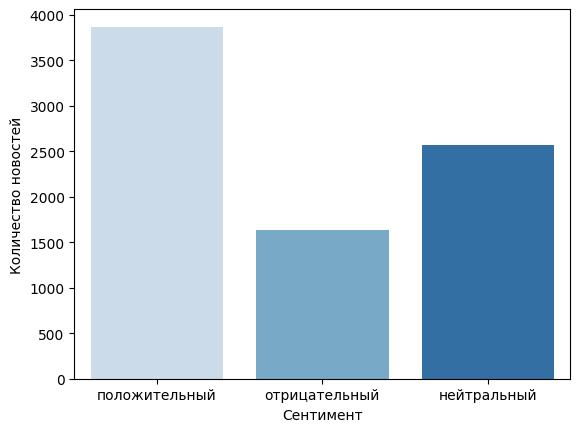

In [ ]:
# Визуализация распределения новостей по группам сентимента
import seaborn as sns
import matplotlib.pyplot as plt

print("Распределение новостей по группам сентимента")
sns.countplot(data=news, x="Sentiment", hue="Sentiment", palette='Blues')

# Добавляем подписи к осям
plt.xlabel("Сентимент")  # Подпись для оси X
plt.ylabel("Количество новостей")  # Подпись для оси Y

In [ ]:
# Запись размеченных данных в файл
news.to_csv('/content/finam_news_scored.csv', index=False, encoding='utf-8')

In [ ]:
# Функция для токенизации текста
def tokenize_function(examples):
    return tokenizer(examples['Title'], padding='max_length', truncation=True, max_length=120)

test = Dataset.from_pandas(news)
tokenized_test = test.map(tokenize_function)

Map:   0%|          | 0/8068 [00:00<?, ? examples/s]

In [ ]:
# Разделение на обучающую и валидационную выборки
X_train, X_test, y_train, y_test = train_test_split(news['Title'], news['Score'], random_state=42,
                                                   shuffle=True, test_size=0.2)

In [ ]:
df_train = pd.DataFrame(data={
    'text': X_train,
    'label': y_train
})
df_test = pd.DataFrame(data={
    'text': X_test,
    'label': y_test
})

In [ ]:
# Преобразование обучающего и валидационного набора данных в формат, ожидаемый моделью и их токенизация
train = Dataset.from_pandas(df_train)
test = Dataset.from_pandas(df_test)
tokenized_train = train.map(token)
tokenized_test = test.map(token)

Map:   0%|          | 0/6454 [00:00<?, ? examples/s]

Map:   0%|          | 0/1614 [00:00<?, ? examples/s]

In [ ]:
# Устанавливаем гиперпараметры
training_args = TrainingArguments(
    output_dir="/content/output/tuned_model_2",
    seed=SEED,
    learning_rate=2e-5,               # скорость обучения
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    num_train_epochs=1,               # количество эпох
    warmup_steps=500,
    eval_strategy="epoch",
    save_strategy="epoch",
    remove_unused_columns=True,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    logging_steps=100,
)

# Инициализация тренера
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)
# Настройка адаптивной скорости обучения
num_training_steps = len(tokenized_train) // training_args.per_device_train_batch_size * training_args.num_train_epochs

# Создание оптимизатора и планировщика
trainer.create_optimizer_and_scheduler(num_training_steps)


<ipython-input-29-aa98e8c0f860>:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Mse,Mae,R2,Accuracy
1,0.014400,0.004613,0.004613,0.049861,0.973369,1.000000


TrainOutput(global_step=202, training_loss=0.014496225421086396, metrics={'train_runtime': 80.158, 'train_samples_per_second': 80.516, 'train_steps_per_second': 2.52, 'total_flos': 76398131190888.0, 'train_loss': 0.014496225421086396, 'epoch': 1.0})

Мы провели дообучение модели на вновь размеченных данных. Увеличение обучающей выборки предсказуемо привело к повышению предсказательной способности модели. Протестируем подход с определением сентимента на основе признака 'score' c присвоением количества баллов по шкале от -1 до 1 на адаптированном наборе данных "Financial Phrasebank", чтобы удостовериться в качестве разметки, прежде чем мы применим данных подход для разметки основного набора данных, на котором будет обучаться классификатор финансового сентимента.

## **Загрузка данных из набора "Financial Phrasebank" и тестирование настроенной модели для разметки новостного сентимента.**

In [ ]:
# Загрузка данных
df = pd.read_excel('/content/Financial_phrasebank_rus .xlsb.xlsx')
df.columns = ['sentence', 'sentiment']
df.head()

,sentence,sentiment
0,"По словам Грана, компания не планирует перенос...",нейтральный
1,Технополис планирует поэтапно развивать террит...,нейтральный
2,Международная компания электронной промышленно...,отрицательный
3,С новым производственным предприятием компания...,положительный
4,В соответствии с обновленной стратегией компан...,положительный


In [ ]:
print('Общее количество записей в файле: ', df.shape[0])
df.drop_duplicates(inplace=True)
print('Общее количество записей после удаления дубликатов: ', df.shape[0])
print('Отсутствующие значения: ', df['sentiment'].isnull().sum())
df.reset_index(inplace=True, drop=True)

Общее количество записей в файле:  8091
Общее количество записей после удаления дубликатов:  7863
Отсутствующие значения:  0


In [ ]:
# Добавим числовое обозначение сентимента: 0 - нейтральный, 1 - отрицательный, 2 - положительный
from sklearn.utils import resample
sent = df.sentiment.unique()
index = [i for i in range(len(sent.tolist()))]
label = dict(zip(sent, index))
# Запишем в колонку 'label'
sent = list(sent)
df['label'] = df.sentiment.replace(label)
df.head()

<ipython-input-33-0097561c7989>:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['label'] = df.sentiment.replace(label)


,sentence,sentiment,label
0,"По словам Грана, компания не планирует перенос...",нейтральный,0
1,Технополис планирует поэтапно развивать террит...,нейтральный,0
2,Международная компания электронной промышленно...,отрицательный,1
3,С новым производственным предприятием компания...,положительный,2
4,В соответствии с обновленной стратегией компан...,положительный,2


In [ ]:
# Найдем максимальную длину заголовка текста (необходимо для передачи параметра max_length в токенизаторе в дальнейшем)
max(df['sentence'].apply(lambda x: len(x)))

387

In [ ]:
fin_phrase = pd.DataFrame(df)

In [ ]:
# Функция токенизации
def tokenize_function(examples):
    return tokenizer(examples['sentence'], padding='max_length', truncation=True, max_length=387)

# Применим функцию токенизации к набору данных
test = Dataset.from_pandas(fin_phrase)
tokenized_test = test.map(tokenize_function)

# Осуществляем разметку
test_trainer = Trainer(model)

# Получаем предсказания по шкале от -1 до 1
raw_pred, _,_ = test_trainer.predict(tokenized_test)

Map:   0%|          | 0/7863 [00:00<?, ? examples/s]

In [ ]:
# Запись предсказаний в колонку 'score' c округлением до 2-х знаков после запятой

fin_phrase['score'] = np.round(raw_pred, 2)

In [ ]:
# Предсказание сентимента на основе score
def get_sentiment(x):

    if  x <= -0.2:
        return 'отрицательный'
    elif x >= 0.2:
        return 'положительный'

    return 'нейтральный'

In [ ]:
# Применение функции ко всем записям в колонке 'Score'
fin_phrase['pred_sentiment'] = fin_phrase['score'].apply(get_sentiment)

In [ ]:
# Вывод первых 10 строк для сравнения истинного и предсказанного сентимента
fin_phrase.head(10)

,sentence,sentiment,label,score,pred_sentiment
0,"По словам Грана, компания не планирует перенос...",нейтральный,0,0.14,нейтральный
1,Технополис планирует поэтапно развивать террит...,нейтральный,0,0.80,положительный
2,Международная компания электронной промышленно...,отрицательный,1,-0.40,отрицательный
3,С новым производственным предприятием компания...,положительный,2,0.71,положительный
4,В соответствии с обновленной стратегией компан...,положительный,2,0.55,положительный
5,ФИНАНСИРОВАНИЕ РОСТА ASPOCOMP Aspocomp агресси...,положительный,2,0.47,положительный
6,За последний квартал 2010 года чистые продажи ...,положительный,2,0.05,нейтральный
7,В третьем квартале 2010 года чистые продажи ув...,положительный,2,0.30,положительный
8,"Операционная прибыль выросла до 13,1 млн. евро...",положительный,2,0.23,положительный
9,"Операционная прибыль составила 21,1 млн. евро ...",положительный,2,0.11,нейтральный


In [ ]:
df_temp, df_test = train_test_split(df, test_size=0.2, random_state=42, stratify=df['sentiment'])
df_train, df_val = train_test_split(df_temp, test_size=0.1, random_state=42, stratify=df_temp['sentiment'])

In [ ]:
print("Размер обучающей выборки: " + str(df_train.shape[0]))
print("Размер валидационной выборки: " + str(df_val.shape[0]))
print("Размер тестовой выборки: " + str(df_test.shape[0]))

Размер обучающей выборки: 5661
Размер валидационной выборки: 629
Размер тестовой выборки: 1573


In [ ]:
# Токенизация и форматирование датасетов

dataset_train = Dataset.from_pandas(df_train)
dataset_val = Dataset.from_pandas(df_val)
dataset_test = Dataset.from_pandas(df_test)

def tokenize_function(example):
    return tokenizer(example['sentence'], truncation=True, padding='max_length', max_length=387)

dataset_train = dataset_train.map(tokenize_function, batched=True)
dataset_val = dataset_val.map(tokenize_function, batched=True)
dataset_test = dataset_test.map(tokenize_function, batched=True)

# Установка формата датасетов для PyTorch
dataset_train.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
dataset_val.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
dataset_test.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

Map:   0%|          | 0/5661 [00:00<?, ? examples/s]

Map:   0%|          | 0/629 [00:00<?, ? examples/s]

Map:   0%|          | 0/1573 [00:00<?, ? examples/s]

In [ ]:
# Оценочные метрики
from sklearn.metrics import precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    # Для мультиклассовой классификации используем 'macro'
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [ ]:
from accelerate import DataLoaderConfiguration, Accelerator

dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
accelerator = Accelerator(dataloader_config=dataloader_config)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    "DeepPavlov/rubert-base-cased-sentence", num_labels=3)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased-sentence and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Устанавливаем гиперпараметры
training_args = TrainingArguments(
    output_dir="/content/output/tuned_classifier",
    seed=SEED,
    learning_rate=2e-5,  # Скорость обучения
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    warmup_steps=500,  # Увеличили количество шагов разогрева
    eval_strategy="epoch",
    save_strategy="epoch",
    remove_unused_columns=True,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    logging_steps=100,  # Шаг логирования
    )

In [ ]:
# Инициализация Trainer
trainer = Trainer(
    model=model,                         # модель
    args=training_args,                  # аргументы обучения, которые мы определили выше
    train_dataset=dataset_train,         # датасет для обучения
    eval_dataset=dataset_val,            # датасет для валидации
    compute_metrics=compute_metrics,     # функция для вычисления метрик
)

# Настройка адаптивного learning rate
num_training_steps = len(dataset_train) // training_args.per_device_train_batch_size * training_args.num_train_epochs

# Создание оптимизатора и scheduler
trainer.create_optimizer_and_scheduler(num_training_steps)

# Начало обучения
trainer.train()

A ConfigError was raised whilst setting the number of model parameters in Weights & Biases config.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.566900,0.448563,0.834658,0.833255,0.834115,0.837780


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.566900,0.448563,0.834658,0.833255,0.834115,0.837780
2,0.430000,0.379462,0.853736,0.855292,0.860493,0.851158
3,0.219800,0.443231,0.856916,0.858006,0.853236,0.864901


TrainOutput(global_step=1062, training_loss=0.47434769826195783, metrics={'train_runtime': 1236.8418, 'train_samples_per_second': 13.731, 'train_steps_per_second': 0.859, 'total_flos': 3377523734486874.0, 'train_loss': 0.47434769826195783, 'epoch': 3.0})

Как видим из сравнения метрик, истинный сентимент и сентимент, предсказанный на основе использованной разметки (score) на валидации совпадают на 86%, что свидетельствует о приемлемом качестве разметки.

In [ ]:
# Получаем предсказания из объекта PredictionOutput
preds = trainer.predict(dataset_test)

# Извлекаем массив предсказаний
predictions_array = preds.predictions

# Получаем индексы классов с максимальными значениями
predicted_classes = np.argmax(predictions_array, axis=1)

df_test = df_test.copy()

df_test['pred_label'] = predicted_classes

df_test.sample(3)

,sentence,sentiment,label,pred_label
5411,"""Энел Россия"" увеличила состав своего правления",положительный,2,2
4472,Ранее сегодня финский конкурент Geberit Uponor...,отрицательный,1,1
2831,При необходимости она также предоставляет допо...,нейтральный,0,0


In [ ]:
# Вывод первых 5 предложений из колонки Sentence
first_five_sentences = df_test['sentence'].head(5)
print(first_five_sentences.to_string(index=True))


7426    По словам Грана, у компании нет планов по пере...
4452    Один из напорных ящиков будет оснащен современ...
1554    Магистр делового администрирования и магистр д...
6258    Владелец Daily Mail рассматривает предложение ...
7715    Как произошло слияние Kraft-Heinz за быстрые 1...


In [ ]:
# Получение вероятностей предсказаний по классам
probs = torch.from_numpy(preds[0]).softmax(1)
predictions = probs.numpy()# преобразуем тензоры в numpy array

new_df = pd.DataFrame(predictions,columns=fin_phrase.sentiment.unique())
new_df.head()

,нейтральный,отрицательный,положительный
0,0.966751,0.021489,0.011760
1,0.974611,0.002365,0.023024
2,0.980119,0.003268,0.016612
3,0.003808,0.005469,0.990723
4,0.007650,0.004252,0.988098


## **Разметка новостных заголовков, собранных за период с 2014 по 2024 гг.**

Используем протестированный выше подход для разметки основного набора данных, который состоит из заголовков русскоязычных новостей из RSS-ленты, собранных за период с 01.01. 2014 по 28.07.2024 гг. и обучим на их основе классификатор тональности.

In [18]:
# Загрузка данных

news = pd.read_csv('/content/news_2014_2024.csv', low_memory=False)


In [19]:
news = news.drop(columns=['Description', 'Source'])
news

,Link,Date,Title
0,https://www.finam.ru/publications/item/dve-tre...,2014-01-01,Две трети россиян не имеют вкладов в банках
1,https://www.finam.ru/publications/item/inflyac...,2014-01-01,"Инфляция в РФ в 2013 году, по предварительным ..."
2,https://www.finam.ru/publications/item/rossiya...,2014-01-01,"Россия начинает председательство в G8, главная..."
3,https://www.finam.ru/publications/item/putin-o...,2014-01-01,Путин обещает продолжить борьбу с террористами...
4,https://www.finam.ru/publications/item/kapital...,2014-01-01,Капитала много не бывает! Сохраняйте и приумно...
...,...,...,...
317630,https://www.finam.ru/publications/item/chto-bu...,2024-07-27,Что будет после повышения ставки
317631,https://www.finam.ru/publications/item/sezon-o...,2024-07-27,"Сезон отпусков поддержит результаты ""Аэрофлота""?"
317632,https://www.finam.ru/publications/item/sliyani...,2024-07-28,Слияние Albertsons и Kroger может не состоятся
317633,https://www.finam.ru/publications/item/v-yapon...,2024-07-28,В Японии создается еще один мощный альянс авто...


In [20]:
# Общая информация о наборе данных
news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 317635 entries, 0 to 317634
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Link    317635 non-null  object
 1   Date    317635 non-null  object
 2   Title   317635 non-null  object
dtypes: object(3)
memory usage: 7.3+ MB


In [21]:
# Найдем максимальную длину заголовка
max_length = max(news['Title'].apply(lambda x: len(x)))
max_length

186

In [22]:
# Инициализация модели

model = my_model


In [23]:
# Выбор токенизатора и создание функции для токенизации текста
tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased-sentence")

In [24]:
# Функция для токенизации текста
def tokenize_function(examples):
    return tokenizer(examples['Title'], padding='max_length', truncation=True, max_length=186)

text = Dataset.from_pandas(news)
tokenized_text = text.map(tokenize_function)

Map:   0%|          | 0/317635 [00:00<?, ? examples/s]

In [25]:
# Применим настроенную модель
text_trainer = Trainer(model)

# Прогноз
raw_pred, _,_ = text_trainer.predict(tokenized_text)

In [26]:
# Запись предсказаний в колонку 'Score' c округлением до 2-х знаков после запятой
news['Score'] = np.round(raw_pred, 2)

In [27]:
# Предсказание сентимента на основе score
def get_sentiment(x):
    if x < -0.3:
      return 'отрицательный'
    if x > 0.3:
        return 'положительный'

    return 'нейтральный'

In [28]:
# Применение функции get_sentiment для получения сентимента
news['Sentiment'] = news['Score'].apply(get_sentiment)
news.head(10)

,Link,Date,Title,Score,Sentiment
0,https://www.finam.ru/publications/item/dve-tre...,2014-01-01,Две трети россиян не имеют вкладов в банках,-0.46,отрицательный
1,https://www.finam.ru/publications/item/inflyac...,2014-01-01,"Инфляция в РФ в 2013 году, по предварительным ...",0.05,нейтральный
2,https://www.finam.ru/publications/item/rossiya...,2014-01-01,"Россия начинает председательство в G8, главная...",0.54,положительный
3,https://www.finam.ru/publications/item/putin-o...,2014-01-01,Путин обещает продолжить борьбу с террористами...,-0.07,нейтральный
4,https://www.finam.ru/publications/item/kapital...,2014-01-01,Капитала много не бывает! Сохраняйте и приумно...,-0.04,нейтральный
5,https://www.finam.ru/publications/item/scenari...,2014-01-01,Сценарии и прогнозы: 2013 - положительные итог...,0.49,положительный
6,https://www.finam.ru/publications/item/scenari...,2014-01-01,Сценарии и прогнозы: Возврат к устойчивому рос...,-0.10,нейтральный
7,https://www.finam.ru/publications/item/sovmest...,2014-01-01,Совместный труд объединяет. Успешного Нового г...,0.51,положительный
8,https://www.finam.ru/publications/item/po-itog...,2014-01-01,По итогам торгов на фондовых рынках США 31.12....,0.21,нейтральный
9,https://www.finam.ru/publications/item/cena-na...,2014-01-01,Цена на фьючерсы на нефть марки Light с постав...,-0.24,нейтральный


Распределение новостей по группам сентимента


Text(0, 0.5, 'Количество новостей')

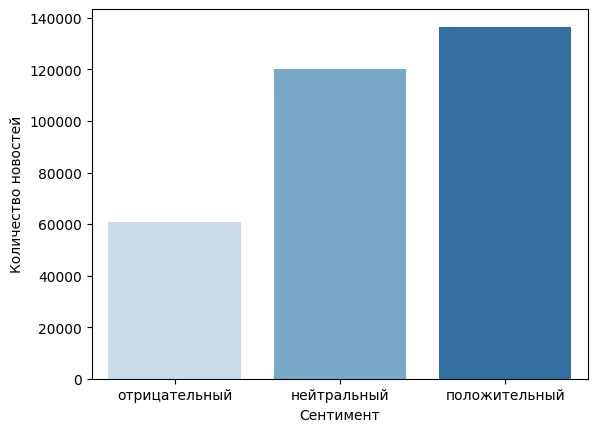

In [29]:
# Визуализация распределения новостей по группам сентимента
import seaborn as sns
import matplotlib.pyplot as plt

print("Распределение новостей по группам сентимента")
sns.countplot(data=news, x="Sentiment", hue="Sentiment", palette='Blues')

# Добавляем подписи к осям
plt.xlabel("Сентимент")  # Подпись для оси X
plt.ylabel("Количество новостей")  # Подпись для оси Y

In [30]:
# Запись результатов в файл
news.to_csv('news_2014_2024_scored.csv', index=False, encoding='utf-8')


# **Предварительный анализ размеченного сентимента 2014-2024.**

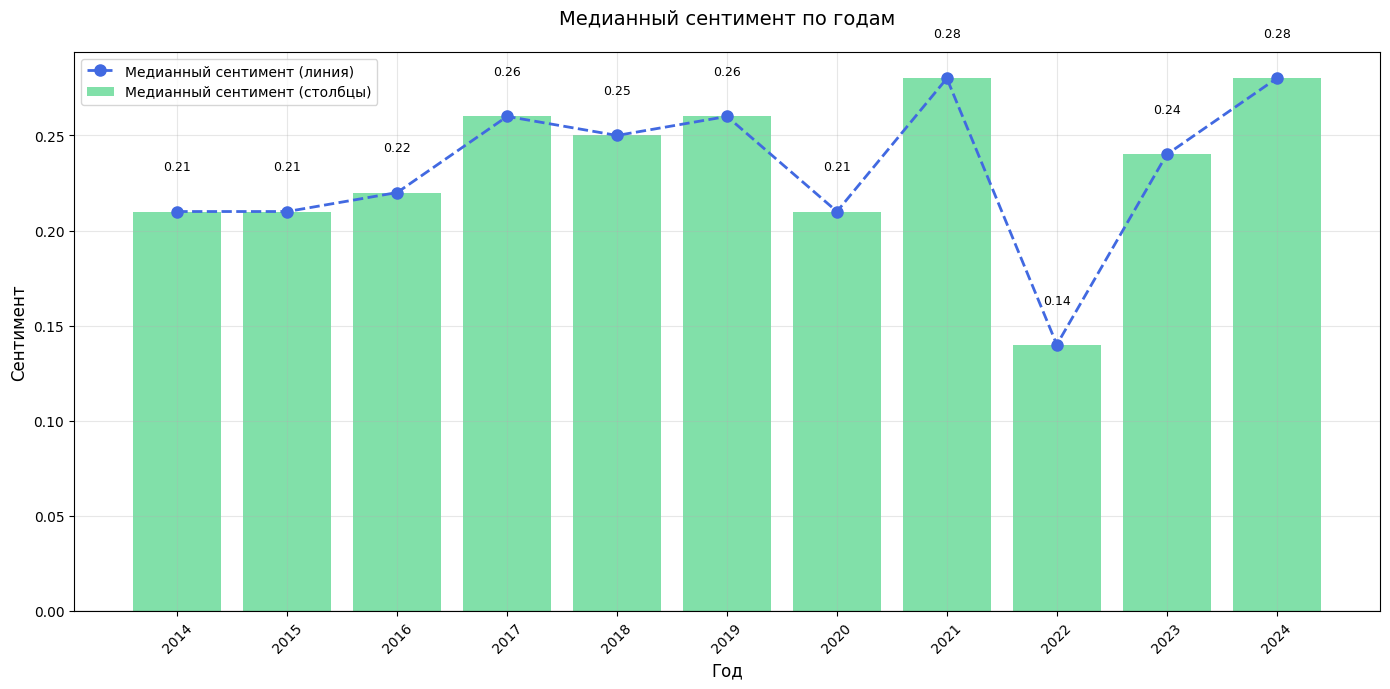

In [31]:
# Загрузка и подготовка данных
news = pd.read_csv('news_2014_2024_scored.csv')
news['Date'] = pd.to_datetime(news['Date'])
news['Year'] = news['Date'].dt.year

# Группировка данных
sentiment_by_year = news.groupby('Year')['Score'].median().reset_index()

# Создание комбинированного графика
plt.figure(figsize=(14, 7))

# Бар-чарт с цветовым кодированием
bars = plt.bar(sentiment_by_year['Year'],
               sentiment_by_year['Score'],
               color=['#2ecc71' if x >=0 else '#e74c3c' for x in sentiment_by_year['Score']],
               alpha=0.6,  # Прозрачность для лучшей видимости линии
               label='Медианный сентимент (столбцы)')

# Линейный график поверх столбцов
line = plt.plot(sentiment_by_year['Year'],
                sentiment_by_year['Score'],
                marker='o',
                linestyle='--',
                color='royalblue',
                linewidth=2,
                markersize=8,
                label='Медианный сентимент (линия)')

# Настройка оформления
plt.title('Медианный сентимент по годам', fontsize=14, pad=20)
plt.xlabel('Год', fontsize=12)
plt.ylabel('Сентимент', fontsize=12)
plt.axhline(0, color='black', linewidth=0.8)
plt.grid(alpha=0.3)
plt.xticks(sentiment_by_year['Year'], rotation=45)
plt.legend(loc='best')
plt.tight_layout()

# Добавление аннотаций значений
for year, score in zip(sentiment_by_year['Year'], sentiment_by_year['Score']):
    plt.text(year,
             score + 0.02 * (1 if score >=0 else -1),  # Смещение надписи
             f'{score:.2f}',
             ha='center',
             va='bottom' if score >=0 else 'top',
             fontsize=9)

plt.show()


Как видно на графике выше, несмотря на преобладание положительных новостей в новостной повестке, медианный новостной фон остается нейтральным. Исключение составил 2021 год, когда новостной фон был слегка смещен в положительный диапазон.

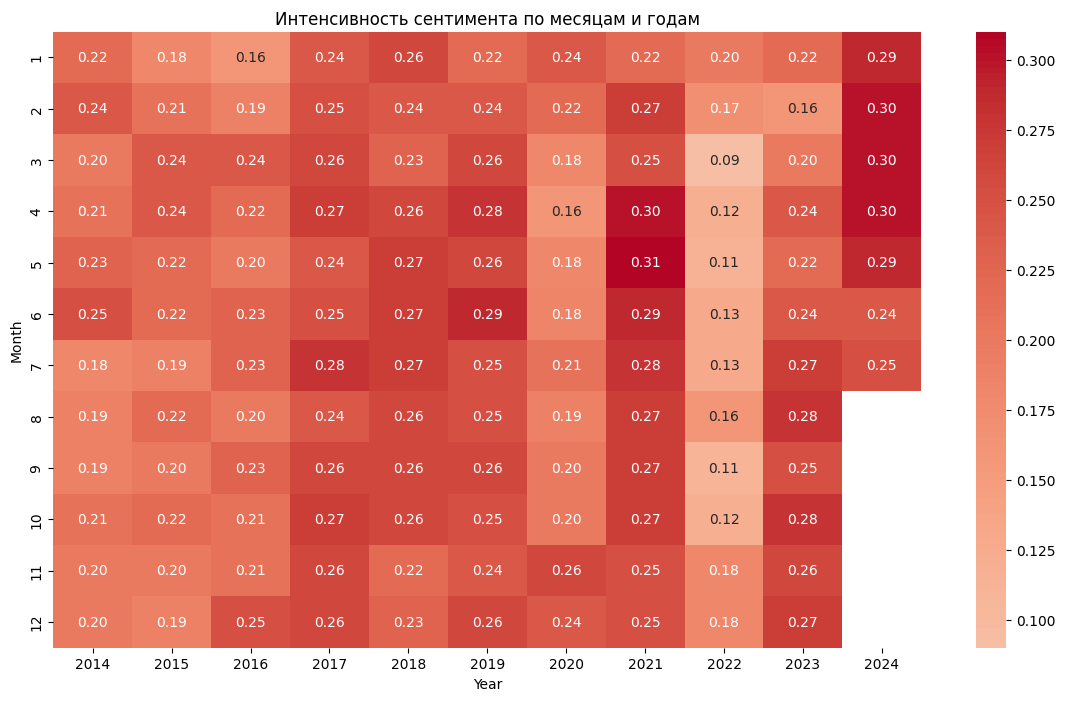

In [32]:
# Добавляем колонку с месяцем
news['Month'] = news['Date'].dt.month

# Создаем сводную таблицу
heatmap_data = news.pivot_table(
    index='Month',
    columns='Year',
    values='Score',
    aggfunc='median'
)

plt.figure(figsize=(14,8))
sns.heatmap(heatmap_data, cmap='coolwarm', center=0, annot=True, fmt=".2f")
plt.title('Интенсивность сентимента по месяцам и годам')
plt.show()

<ipython-input-42-593437d9d3ac>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Year', y='Score', data=news, palette='viridis')
<ipython-input-42-593437d9d3ac>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Year', y='Score', data=news, inner='quartile', palette='coolwarm')


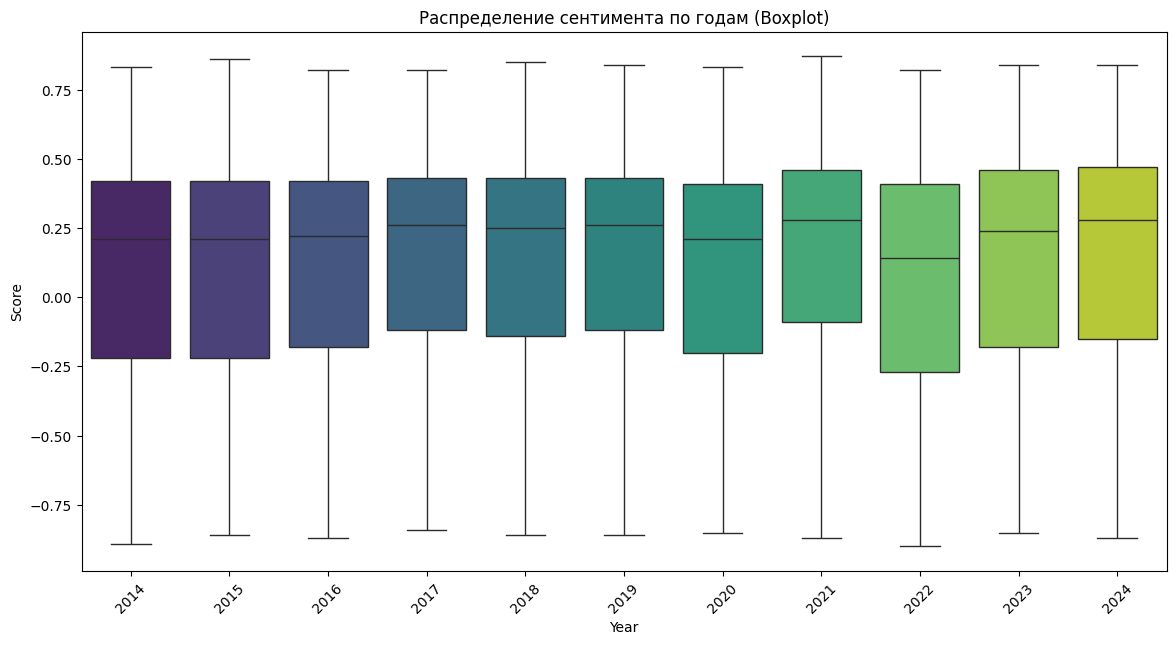

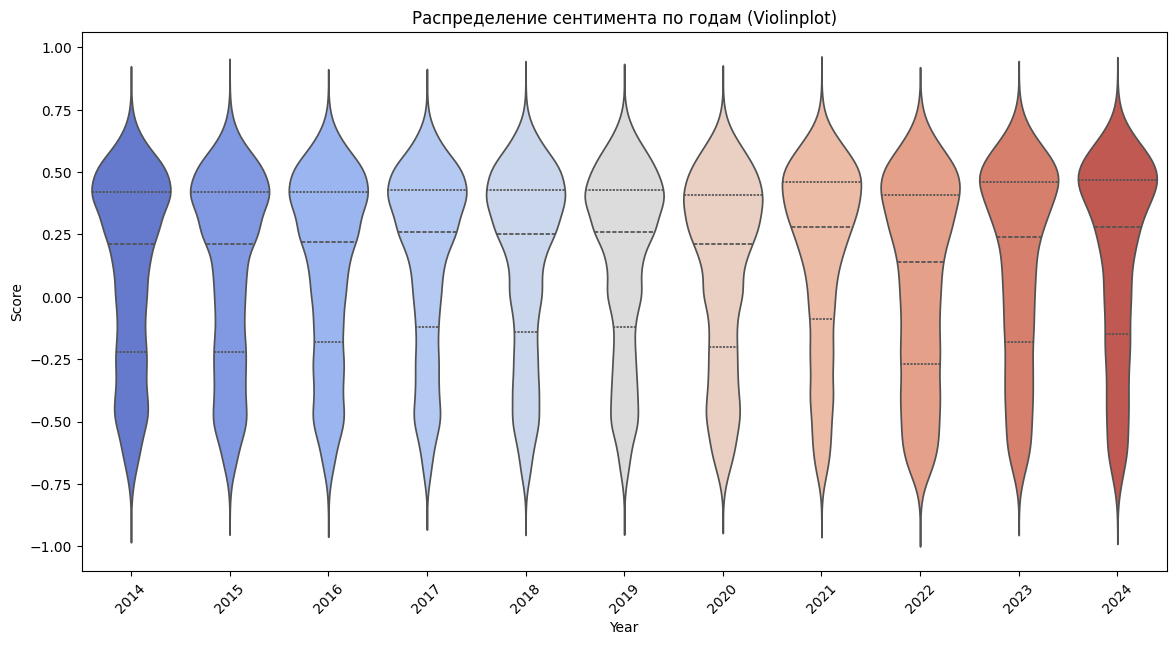

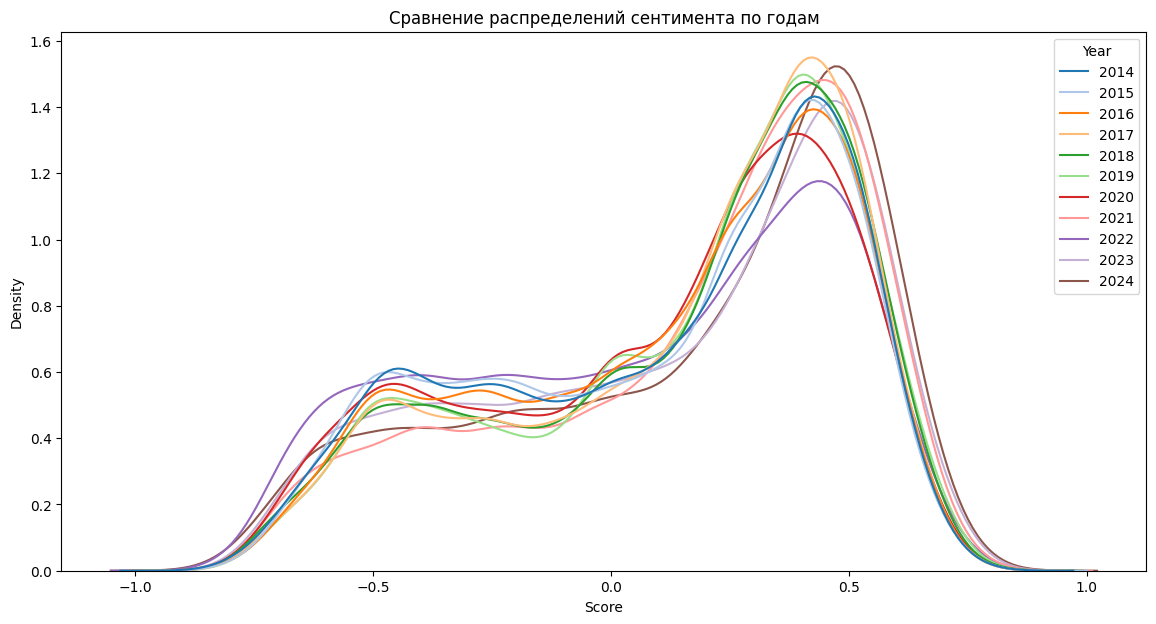

In [42]:
plt.figure(figsize=(14,7))

# Вариант 1: Boxplot
sns.boxplot(x='Year', y='Score', data=news, palette='viridis')
plt.title('Распределение сентимента по годам (Boxplot)')
plt.xticks(rotation=45)

# Вариант 2: Violinplot
plt.figure(figsize=(14,7))
sns.violinplot(x='Year', y='Score', data=news, inner='quartile', palette='coolwarm')
plt.title('Распределение сентимента по годам (Violinplot)')
plt.xticks(rotation=45)

# Вариант 3: Эмпирические распределения
plt.figure(figsize=(14,7))
sns.kdeplot(data=news, x='Score', hue='Year', palette='tab20', common_norm=False)
plt.title('Сравнение распределений сентимента по годам')
plt.show()

In [34]:
# Для месячной аналитики
news['YearMonth'] = news['Date'].dt.to_period('M')

# Для квартальной
news['Quarter'] = news['Date'].dt.quarter

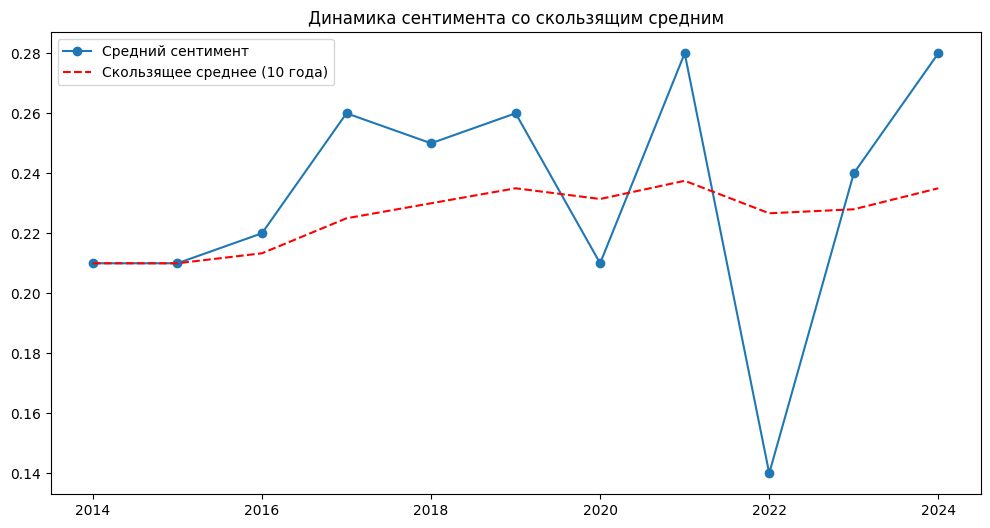

In [35]:
# Добавляем скользящее среднее за 10 лет
window_size = 10
sentiment_by_year['moving_avg'] = sentiment_by_year['Score'].rolling(
    window=window_size,
    min_periods=1
).mean()

# Визуализация
plt.figure(figsize=(12,6))
plt.plot(sentiment_by_year['Year'], sentiment_by_year['Score'], label='Средний сентимент', marker='o')
plt.plot(sentiment_by_year['Year'], sentiment_by_year['moving_avg'],
         label=f'Скользящее среднее ({window_size} года)', linestyle='--', color='red')
plt.legend()
plt.title('Динамика сентимента со скользящим средним')
plt.show()

Несмотря на преобладание нейтрального новостного фона и заметное доминирование класса положительных новостей по сравнению с нейтральными и отрицательными, на графике выше можно видеть, что в периоды биржевых потрясений (2020 и 2022 год) средний сентимент выходит за границы скользящего среднего, демонстрируя в эти периоды нисходящий тренд, что дает более адекватное представление о настроениях на рынке.  

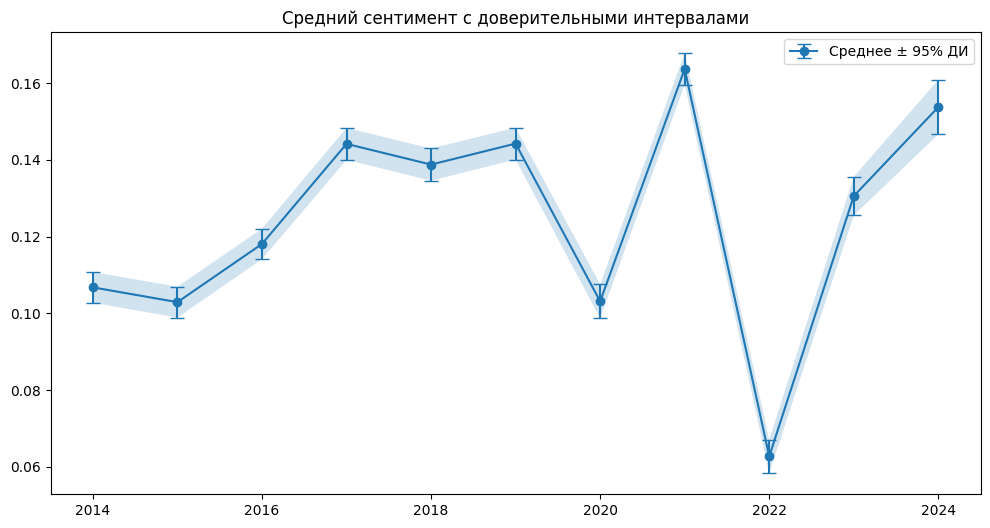

In [36]:
from scipy import stats

# Группировка с расчетом статистик
sentiment_stats = news.groupby('Year')['Score'].agg(
    ['mean', 'count', 'std']
).reset_index()

# Рассчет доверительного интервала (95%)
confidence_level = 0.95
sentiment_stats['ci'] = stats.t.ppf(
    (1 + confidence_level) / 2,
    sentiment_stats['count'] - 1
) * sentiment_stats['std'] / np.sqrt(sentiment_stats['count'])

# Визуализация с интервалами
plt.figure(figsize=(12,6))
plt.errorbar(sentiment_stats['Year'], sentiment_stats['mean'],
             yerr=sentiment_stats['ci'],
             fmt='-o',
             capsize=5,
             label='Среднее ± 95% ДИ')
plt.fill_between(sentiment_stats['Year'],
                 sentiment_stats['mean'] - sentiment_stats['ci'],
                 sentiment_stats['mean'] + sentiment_stats['ci'],
                 alpha=0.2)
plt.title('Средний сентимент с доверительными интервалами')
plt.legend()
plt.show()

In [37]:
from scipy.stats import kruskal

# Подготовка данных
years = sorted(news['Year'].unique())
samples = [news[news['Year'] == year]['Score'] for year in years]

# Тест Краскела-Уоллиса
stat, p_value = kruskal(*samples)
print(f"Kruskal-Wallis H-test:\nH-statistic = {stat:.3f}, p-value = {p_value:.4f}")

# Интерпретация
alpha = 0.05
if p_value < alpha:
    print("Есть статистически значимые различия между распределениями хотя бы в двух годах")
else:
    print("Нет значимых различий между распределениями")

Kruskal-Wallis H-test:
H-statistic = 1722.366, p-value = 0.0000
Есть статистически значимые различия между распределениями хотя бы в двух годах


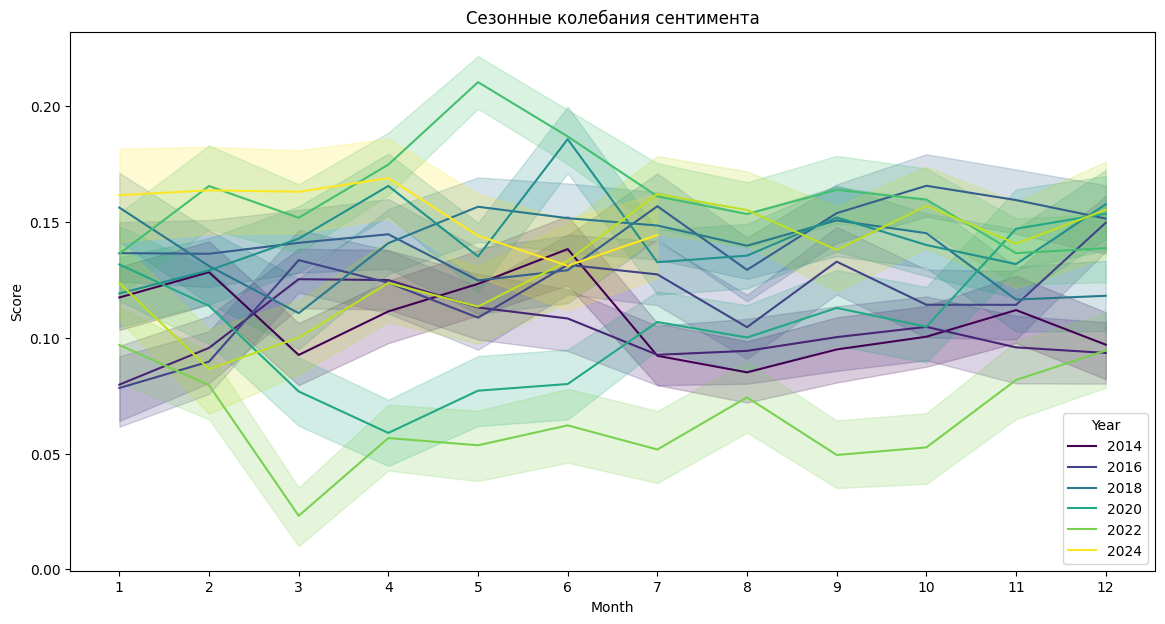

In [40]:
# Добавляем месяц
news['Month'] = news['Date'].dt.month

# Визуализация сезонности
plt.figure(figsize=(14,7))
sns.lineplot(data=news, x='Month', y='Score', hue='Year',
             palette='viridis', estimator='mean', errorbar=('ci', 95))
plt.title('Сезонные колебания сентимента')
plt.xticks(range(1,13))
plt.show()

Сезонные колебания сентимента связаны в основном с периодами выхода отчетности и могут вносить вклад в повышение волатильности на рынке в эти периоды.